# **ALESSANDRO MACCARIO**
# Matriculation number: **12116666**
# COURSE OF: LABOR "FUNDAMENTAL IMAGE PROCESSING"
### Professor Perumadura Meluka Nadeesh De Silva, M.Sc.
### Professor Dr. Vahid Tavakkoli, MSc.

# **DOCUMENT-SCANNER PROJECT USING OPENCV**





---



---



In [274]:
# load the required libraries
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local

# WHY RESIZE IT?
You’ll generally be decreasing the size of an image rather than increasing (exceptions do apply, of course). By decreasing the image size, we have fewer pixels to process (not to mention less “noise” to deal with), which leads to faster and more accurate image processing algorithms.

So, in order to speedup image processing, 
as well as make our edge detection step more accurate, 
we resize our scanned image.

In [275]:
# set parameters for figure size dynamically in matplotlib 
plt.rcParams['figure.figsize'] = [16,10]

# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it

image = cv2.imread('receipt_1.JPG')
# We keep track of the ratio because we'll resize our image based o that later.
# Right now we need a resized image because it's simpler for the algorithm to be
# faster.
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height=500)

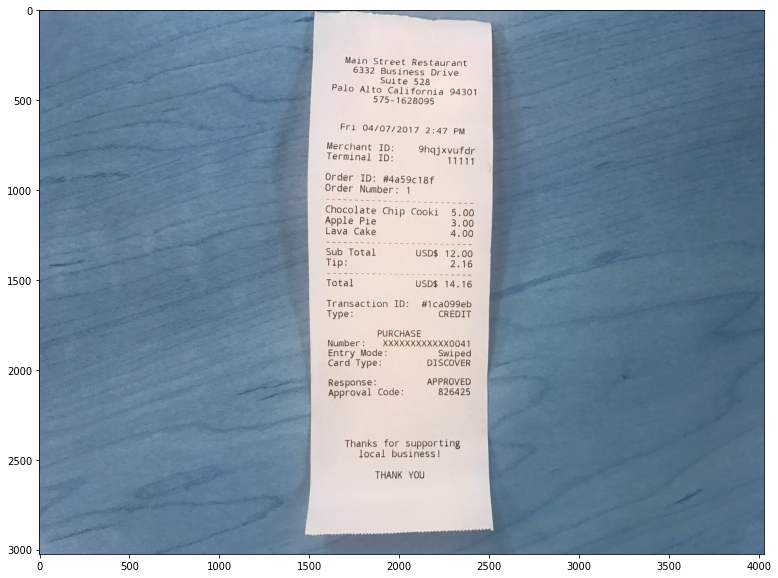

In [276]:
# Show the image
plt.imshow(orig)

We convert the image from RGB to grayscale and perform Gaussian blurring to remove high frequency noise (aiding in contour detection in Step 2), and perform Canny edge detection on Line 26.

# WHY GRAYSCALE?
For other algorithms to work: Many algorithms are customized to work only on grayscale images e.g. Canny edge detection function pre-implemented in OpenCV library works on Grayscale images only.

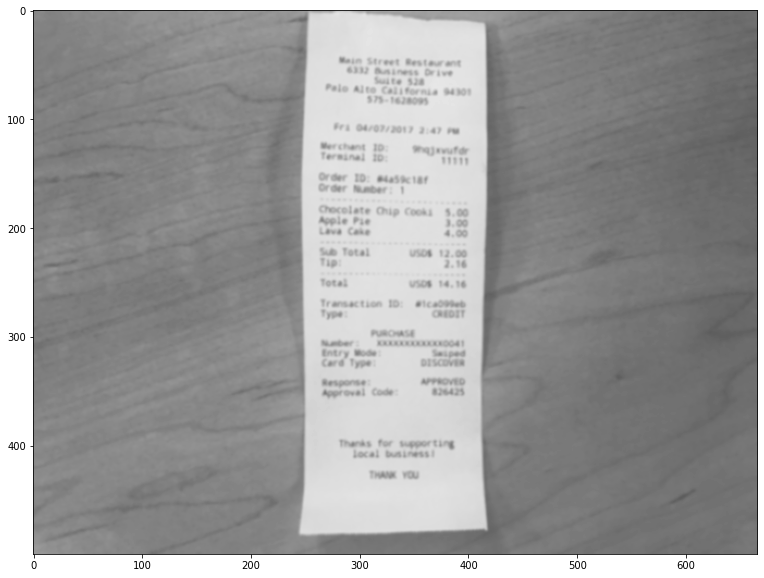

In [277]:
# convert the image to grayscale, blur it, and find edges
# in the image

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)

# Show the image
plt.imshow(gray, cmap="gray", vmin=0, vmax=255)

Canny Edge Detection is a popular edge detection algorithm that follows the following steps:

 1. Noise Reduction: Since edge detection is susceptible to noise in the image, first step is to remove the noise in the image (with a 5x5 Gaussian filter).

 2. Finding Intensity Gradient of the Image: Smoothened image is then filtered with a Sobel kernel in both horizontal and vertical direction to get first derivative in horizontal direction (Gx) and vertical direction (Gy). From these two images, we can find edge gradient and direction for each pixel.

 3. Non-maximum Suppression: After getting gradient magnitude and direction, a full scan of image is done to remove any unwanted pixels which may not constitute the edge. For this, at every pixel, pixel is checked if it is a local maximum in its neighborhood in the direction of gradient.

 4. Hysteresis Thresholding: This stage decides which are all edges are really edges and which are not.
For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges
based on their connectivity. If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded.
So what we finally get is strong edges in the image.

What it does is, basically, use the Sobel operator (it works on grayscale image)
to get rid of edges that we're not really interested and keep only the ones useful for us.
So, the input of the Canny Operator is simply the output of Sobel:
 - so, we've taken over an image we've converted to gray scale;
 - we've ran our Gaussian Blur
 - and then we've run our Sobel operator in both X & Y directions
 - we've calculated the gradient and the orientation of those
 - now we've ready for the Canny process

Because the Sobel Kernel is very noisy: we're using a small kernel and images changes a lot.
So, you're going to see a lot of edges where it's not actually really an edge in our sense of the word.
Another thing would be if you had a camera with a farirly high ISO setting, you get a lot of Grainy noise,
that's gonna produce the though of low-level edge over everything wich is not what we want.
So, it's very common to use a Gaussian Blur first, before Sobel edge detector just to get rid of the high frequency
and keep the low frequency that we're looking for.
So:
 - gray scale conversion;
 - use a Gaussian Filter;
 - use a Sober Edge Detector
That produce a black and white image where big white bright edges and dark everything else.

Link: https://www.youtube.com/watch?v=uihBwtPIBxM

Canny works by taking the image from the Sobel output, thinning all the edges so they are 1 pixel wide,
because the only thing that we need is where the edges are and not how thick they are.
Canny works by:
 - first finding the edges;
 - use a process called hysteresis thresholding: is essentially a two level threshold

So, for every pixel, the first thing is try to find out if its a local maximum (that means that is
bigger than its neighbors (bear in mind the orientation of the Sober).
The second stage, is remove the edges that even though we weren't over maximum, there still not very useful
to use because they're really weak response (so noise, basically: we want to create an image of the dominate edges, and preserve only that).
For that we use a process called hysteresis thresholding (look before)


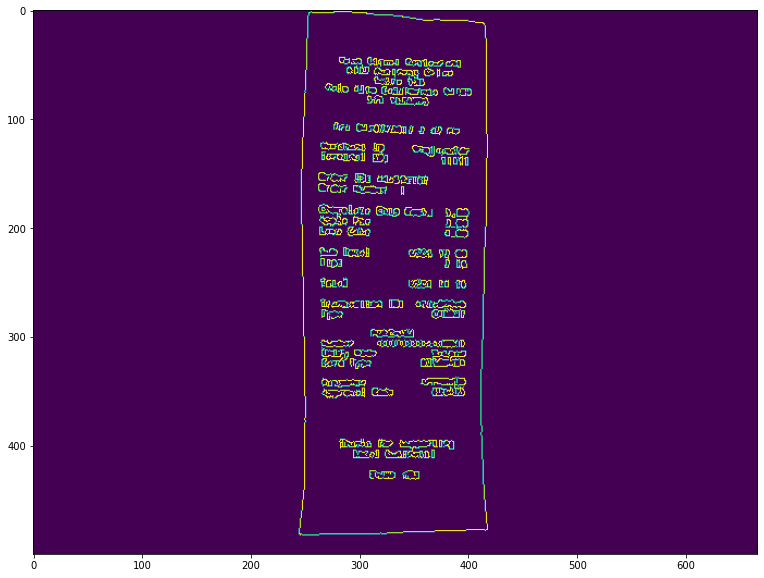

In [278]:
# apply the Canny Algorithm with min and max values to
# edged = cv2.Canny(gray, 75, 200) # minVal, maxVal
edged = cv2.Canny(gray, 15, 155) # minVal, maxVal

# Check the image
plt.imshow(edged)

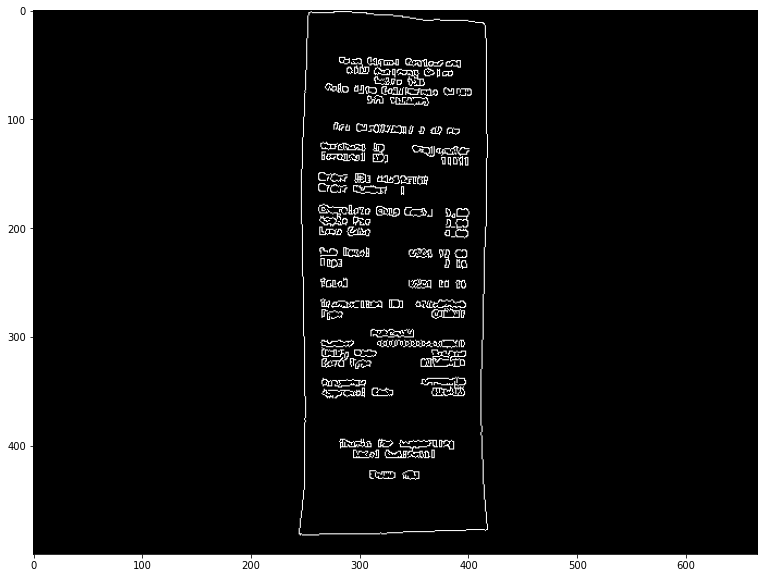

In [279]:
  # Use cv2.cvtColor() method to convert an image from one color space to another
  dispImage = cv2.cvtColor(edged.copy(), cv2.COLOR_GRAY2RGB)
  plt.imshow(dispImage)

In [ ]:
# find the contours in the edged image, keeping only the
# largest five, and initialize the screen contour.
# there are three arguments in cv.findContours() function, 
# first one is source image, second is contour retrieval mode 
# (RETR_TREE: retrieves all of the contours and reconstructs a full hierarchy of nested contours.), 
# third is contour approximation method.  And it outputs the contours and hierarchy.
# Contours is a Python list of all the contours in the image. 
# Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
contours = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [281]:
contours = imutils.grab_contours(contours)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]

# How cv2.arcLength() and cv2.approxPolyDP() works?
 - cv2.arcLength(): It is used to calculate the perimeter of the contour. If the second argument is True then it considers the contour to be closed.

- cv2.approxPolyDP(): It approximates a contour shape to another shape with less number of vertices depending upon the precision we specify.
It is an implementation of Douglas-Peucker algorithm.
To understand this, suppose you are trying to find a square in an image, but due to some problems in the image, you didn't get a perfect square, but a "bad shape" (As shown in first image below).
Now you can use this function to approximate the shape.
In this, second argument is called epsilon, which is maximum distance from contour to approximated contour. It is an accuracy parameter.
A wise selection of epsilon is needed to get the correct output.

In [282]:
# In OpenCV, finding contours is like finding white object from
# black background. So remember, object to be found should be white and 
# background should be black.

for c in contours:
    perimeter = cv2.arcLength(c, True) # (curve, closed = True/False)
    approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    
    # if our approximated contour has four points
    # (read the result as anti-clockwise, starting to the top-left)
    if len(approx) == 4:
        screenContour = approx
        print(screenContour)
        break

[[[255   1]]

 [[244 481]]

 [[415 478]]

 [[415  14]]]


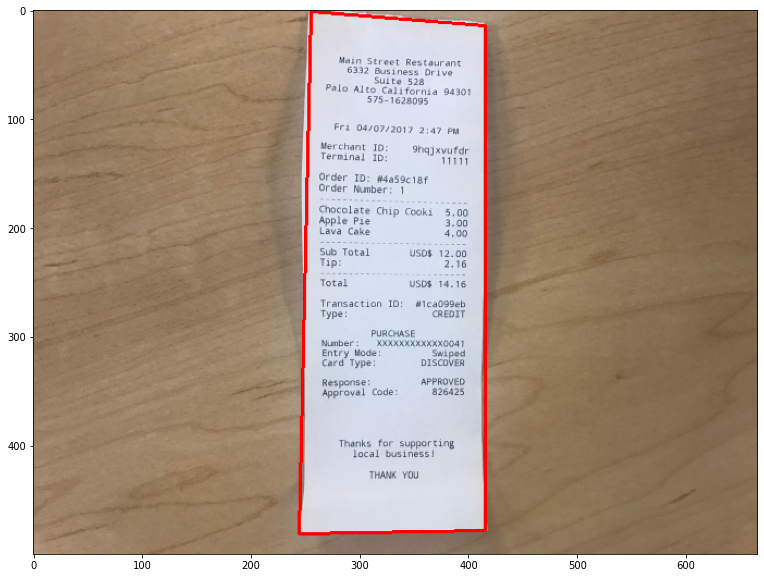

In [283]:
# draw contours based on screenContour that contains the four contours for the 
# main object of the image
cv2.drawContours(image, [screenContour], -1, (0,0,255), 2) # -1 => draw all contours, (color), thickness
dispImage = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
plt.imshow(dispImage)

In [284]:
# In order to calculate the Euclidean Distance in the Four-Points-Transformations
# we need to order the four points of the document.
# That's because it will be simpler to create the rect matrix composed by
# the new coordinates already ordered.

def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    
    # the top-left point will have the smallest sum, whereas the bottom-right 
    # point will have the largest sum
    s = pts.sum(axis = 1)
    print(s)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # the top-right point will have the smallest difference, 
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [285]:
# The image variable is the image we want to apply the perspective transform to. 
# And the pts list is the list of four points that contain the ROI 
# (Region of Interests = an area of an image defined for further analysis or processing)
# of the image we want to transform.
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them individually
    # Notice how our points are now stored in an imposed order: 
    # top-left, top-right, bottom-right, and bottom-left. 
    # Keeping a consistent order is important when 
    # we apply our perspective transformation.
    rect = order_points(pts)
    
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    # THIS IS BECAUSE YOU ARE APPROXIMATING THE DISTANCE AND YOU HAVE TO FIND
    # THE MAXIMUM VALUE OF WIDTH

    # CALCULATE THE EUCLIDEAN DISTANCE
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    # THIS IS BECAUSE YOU ARE APPROXIMATING THE DISTANCE AND YOU HAVE TO FIND
    # THE MAXIMUM VALUE OF HEIGHT
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # Here, we define 4 points representing our “top-down” view of the image. 
    # The first entry in the list is (0, 0) indicating the top-left corner. 
    # The second entry is (maxWidth - 1, 0) which corresponds to the top-right
    # corner. Then we have (maxWidth - 1, maxHeight - 1) which is the 
    # bottom-right corner. Finally, we have (0, maxHeight - 1) which is the 
    # bottom-left corner.
    # The takeaway here is that these points are defined in a consistent 
    # ordering representation — and will allow us to obtain the 
    # top-down view of the image.

    destinationPoints = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype = "float32")
    print(destinationPoints)
    # compute the perspective transform matrix: 
    # apply the transformation matrix to obtain the new and correct one, transformed
    # To actually obtain the top-down, “birds eye view” of the image we’ll
    # utilize the cv2.getPerspectiveTransform function on Line 60. 
    # This function requires two arguments, rect, which is the list of 4 
    # ROI points in the original image, and dst, which is our list of 
    # transformed points. The cv2.getPerspectiveTransform function returns M, 
    # which is the actual transformation matrix.

    mapped = cv2.getPerspectiveTransform(rect, destinationPoints)

    # We apply the transformation matrix on Line 61 using the cv2.warpPerspective
    # function. We pass in the image, our transform matrix M, 
    # along with the width and height of our output image. 
    # The output of cv2.warpPerspective is our warped image, which is our top-down view.
    warped = cv2.warpPerspective(image, mapped, (maxWidth, maxHeight))
    
    return warped

In [286]:
# apply the four point transform to obtain a top-down view of the original image
warped = four_point_transform(orig, screenContour.reshape(4, 2) * ratio)

[1548.288 4384.8   5400.864 2594.592]
[[   0.    0.]
 [1033.    0.]
 [1033. 2902.]
 [   0. 2902.]]


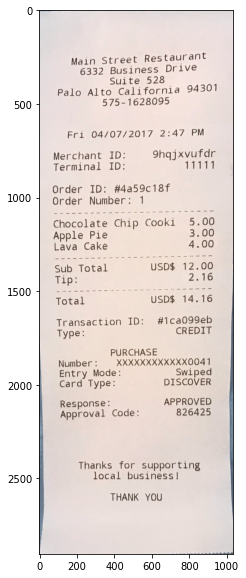

In [287]:
plt.imshow(warped)

In [288]:
# convert the warped image to grayscale, then threshold it to give it that 'black and white' paper effect.
# The thresholding tecnique is used for converting the image to binary so you can separate the
# background from the foreground more easily.
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

# Create a threshold:
# Sometimes, it isn't that obvious to identify the background. 
# If the image background is relatively uniform, then you can use a 
# global threshold value using threshold_otsu(). 
# However, if there's uneven background illumination, 
# adaptive thresholding threshold_local() 
# (a.k.a. local thresholding) may produce better results.
T = threshold_local(warped, 11, offset = 10, method = "gaussian")

warped = (warped > T).astype("uint8") * 255

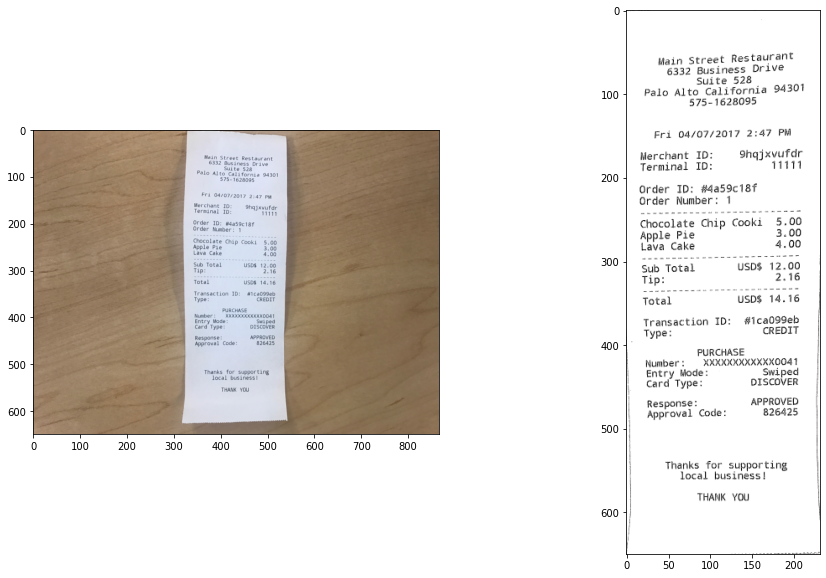

In [289]:
# resizing
origImage = imutils.resize(orig, height = 650)
dispImage = imutils.resize(warped, height = 650)

dispImage = cv2.cvtColor(dispImage, cv2.COLOR_GRAY2RGB)
origImage = cv2.cvtColor(origImage, cv2.COLOR_BGR2RGB)

# Plotting the original and the final image
plt.subplot(1, 2, 1)
plt.imshow(origImage)
plt.subplot(1, 2, 2)
plt.imshow(dispImage)
plt.show()